✅ RFM data loaded successfully!

--- 6.2 Scaling RFM features ---
Data scaled successfully. Displaying first 5 rows of scaled data:


,Recency,Frequency,MonetaryValue
Customer ID,,,
12346,0.762299,0.801087,-0.187961
12347,-0.910402,-0.300603,-0.081329
12348,-0.177305,-0.423013,-0.204868
12349,-0.497389,-0.178193,0.069883
12351,-0.827799,-0.423013,-0.196031


------------------------------

--- 6.3 Finding optimal 'K' with the Elbow Method ---


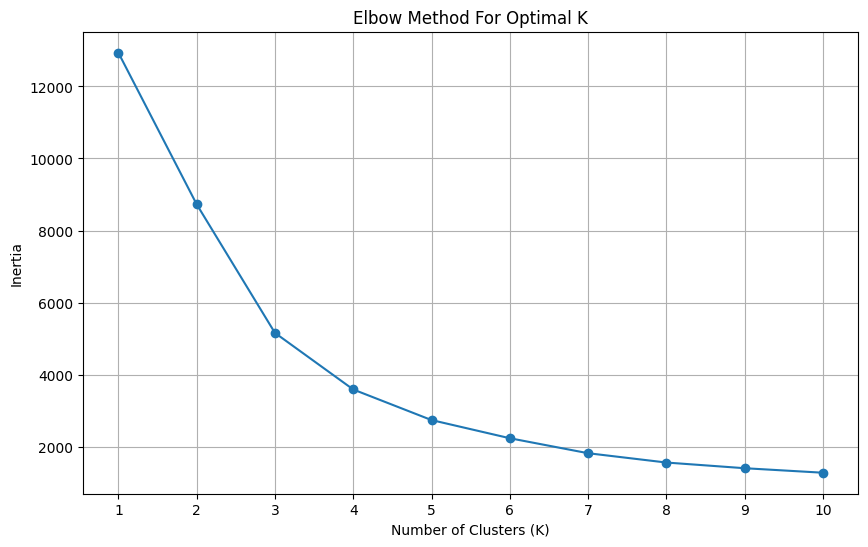

In [2]:
# =============================================================================
# Step 6: Machine Learning Modeling with K-Means Clustering
# =============================================================================
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# --- 6.1 Load the Processed RFM Data ---
# Load the RFM data we saved in the previous notebook.
try:
    rfm_df = pd.read_csv('../01_data/processed/rfm_customer_data.csv')
    # Set Customer ID as the index if it's not already
    if 'Customer ID' in rfm_df.columns:
        rfm_df.set_index('Customer ID', inplace=True)
    print("✅ RFM data loaded successfully!")
except FileNotFoundError:
    print("❌ Error: Could not find 'rfm_customer_data.csv'. Please ensure the previous steps were run.")

# Select the features for clustering
rfm_features = rfm_df[['Recency', 'Frequency', 'MonetaryValue']]


# --- 6.2 Scale the Data ---
# K-Means is sensitive to the scale of the data. For example, MonetaryValue has a much larger
# range than Frequency. We need to scale the data so all features have a similar importance.
print("\n--- 6.2 Scaling RFM features ---")
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_features)
rfm_scaled = pd.DataFrame(rfm_scaled, index=rfm_features.index, columns=rfm_features.columns)

print("Data scaled successfully. Displaying first 5 rows of scaled data:")
display(rfm_scaled.head())
print("-" * 30)


# --- 6.3 Find the Optimal Number of Clusters (The Elbow Method) ---
# We need to tell K-Means how many clusters ('K') to find. The Elbow Method is a popular
# way to determine this. We run K-Means for a range of K values and plot the 'inertia'.
# The 'elbow' of the curve indicates the best K.
print("\n--- 6.3 Finding optimal 'K' with the Elbow Method ---")
inertia = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    inertia[k] = kmeans.inertia_

# Plot the Elbow Method curve
plt.figure(figsize=(10, 6))
plt.plot(list(inertia.keys()), list(inertia.values()), 'o-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal K')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show() # CORRECTED: Use plt.show() to display the plot in a Jupyter Notebook

In [3]:
# =============================================================================
# Step 6.4: Build the K-Means Model with K=4
# =============================================================================
import plotly.express as px

# We are assuming 'rfm_df' and 'rfm_scaled' are loaded and calculated from previous cells.
optimal_k = 4

print(f"--- 6.4 Building K-Means model with K={optimal_k} ---")

# Initialize and fit the K-Means model
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans.fit(rfm_scaled)

# Assign the cluster labels back to our original RFM dataframe
rfm_df['K_Cluster'] = kmeans.labels_

print("Assigned machine learning-driven cluster ID to each customer.")
display(rfm_df.head())
print("-" * 30)


# =============================================================================
# Step 6.5: Analyze the Machine Learning-Driven Segments
# =============================================================================
print("\n--- 6.5 Analyzing the K-Means Segments ---")

# Group by the new 'K_Cluster' column to understand the characteristics
ml_segment_analysis = rfm_df.groupby('K_Cluster').agg(
    Recency_mean=('Recency', 'mean'),
    Frequency_mean=('Frequency', 'mean'),
    MonetaryValue_mean=('MonetaryValue', 'mean'),
    Customer_Count=('Recency', 'count')
).round(1)

print("Summary of ML-driven customer segments:")
display(ml_segment_analysis.sort_values(by='MonetaryValue_mean', ascending=False))
print("-" * 30)

# =============================================================================
# Step 6.6: Visualize the Clusters in 3D
# =============================================================================
print("\n--- 6.6 Visualizing the clusters ---")
fig = px.scatter_3d(
    rfm_df,
    x='Recency',
    y='Frequency',
    z='MonetaryValue',
    color='K_Cluster',
    title='3D Visualization of Customer Segments by K-Means',
    labels={'K_Cluster': 'Customer Segment'},
    opacity=0.7,
    width=900,
    height=800
)

# Use fig.show() to display the interactive plot in your notebook
fig.show()

--- 6.4 Building K-Means model with K=4 ---
Assigned machine learning-driven cluster ID to each customer.


,Recency,Frequency,MonetaryValue,R_score,F_score,M_score,RFM_Segment,RFM_Score,K_Cluster
Customer ID,,,,,,,,,
12346,165,11,372.86,1,4,2,1.04.02.0,7,1
12347,3,2,1323.32,4,2,3,4.02.03.0,9,0
12348,74,1,222.16,2,1,1,2.01.01.0,4,0
12349,43,3,2671.14,3,3,4,3.03.04.0,10,0
12351,11,1,300.93,4,1,1,4.01.01.0,6,0


------------------------------

--- 6.5 Analyzing the K-Means Segments ---
Summary of ML-driven customer segments:


,Recency_mean,Frequency_mean,MonetaryValue_mean,Customer_Count
K_Cluster,,,,
2,5.6,113.6,215543.7,5
3,14.3,46.0,28018.4,59
0,43.1,4.4,1710.8,3201
1,243.0,1.7,596.9,1047


------------------------------

--- 6.6 Visualizing the clusters ---


In [ ]:
# =============================================================================
# Step 7: Predictive Modeling - Churn Prediction
# =============================================================================
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

print("--- 7.1 Preparing Data for Predictive Modeling ---")
# We are assuming 'rfm_df' is loaded from the previous steps in this notebook

# Define the Churn Status (our target variable 'y')
churn_threshold = 180
rfm_df['Churn_Status'] = (rfm_df['Recency'] > churn_threshold).astype(int) # 1 for Churned, 0 for Active

# Define the features we will use for prediction ('X')
features = ['Recency', 'Frequency', 'MonetaryValue', 'RFM_Score']
X = rfm_df[features]
y = rfm_df['Churn_Status']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print(f"Data split into {len(X_train)} training samples and {len(X_test)} testing samples.")

print("\n--- 7.2 Training a Logistic Regression Model ---")
# We use Logistic Regression because it's simple, interpretable, and gives probabilities.
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)
print("Model training complete.")

# Evaluate the model's performance on the test set
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy on Test Set: {accuracy:.2%}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\n--- 7.3 Generating Churn Probabilities for All Customers ---")
# Use the trained model to predict the probability of churn for every customer
churn_probabilities = model.predict_proba(rfm_df[features])[:, 1] # Get probability of being '1' (Churned)
rfm_df['Churn_Probability'] = churn_probabilities

print("Churn probabilities calculated and added to the dataframe.")

# --- 7.4 Saving the Final Data for the Dashboard ---
# This new file will contain everything needed for the final dashboard
final_data_path = '../01_data/processed/final_dashboard_data.csv'
rfm_df.to_csv(final_data_path)
print(f"\n✅ Final data with churn predictions saved to: {final_data_path}")

--- 7.1 Preparing Data for Predictive Modeling ---
Data split into 3018 training samples and 1294 testing samples.

--- 7.2 Training a Logistic Regression Model ---
Model training complete.

Model Accuracy on Test Set: 87.09%

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      1046
           1       0.67      0.65      0.66       248

    accuracy                           0.87      1294
   macro avg       0.79      0.78      0.79      1294
weighted avg       0.87      0.87      0.87      1294


--- 7.3 Generating Churn Probabilities for All Customers ---
Churn probabilities calculated and added to the dataframe.

✅ TEST MODE: Final data frame was not saved to a file.


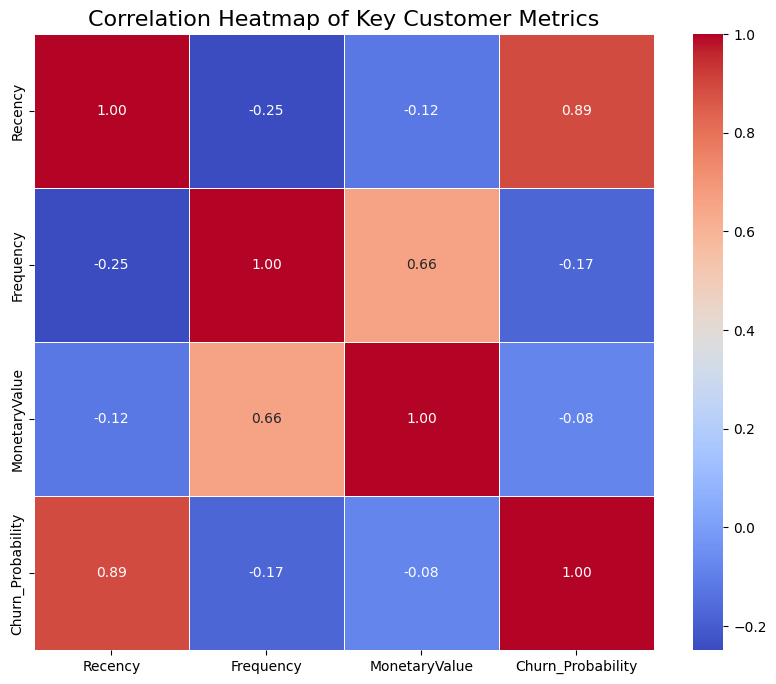

In [20]:
# =============================================================================
# Insight: Correlation Heatmap Analysis
# =============================================================================
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

# --- Load Data ---
# This line is crucial if you are running this cell independently.
# It ensures the necessary dataframe is loaded into memory.
# We use a robust path to avoid file location errors.
project_root = Path().resolve().parent
customer_data_path = project_root / "01_data" / "processed" / "final_dashboard_data.csv"
customer_df = pd.read_csv(customer_data_path)


# 1. Select the key numerical variables for the correlation analysis.
# These are the most interesting features to compare.
correlation_features = [
    'Recency', 
    'Frequency', 
    'MonetaryValue', 
    'Churn_Probability'
]
heatmap_df = customer_df[correlation_features]

# 2. Calculate the correlation matrix.
# The .corr() method calculates the Pearson correlation coefficient between all pairs of columns.
correlation_matrix = heatmap_df.corr()

# 3. Create the heatmap plot using Seaborn.
plt.figure(figsize=(10, 8)) # Set the size of the figure
sns.heatmap(
    correlation_matrix, 
    annot=True,         # This displays the correlation values on the heatmap.
    cmap='coolwarm',    # Use a color map where warm colors = positive, cool colors = negative.
    fmt=".2f",          # Format the numbers to two decimal places.
    linewidths=.5
)

# 4. Add a title and display the plot.
plt.title('Correlation Heatmap of Key Customer Metrics', fontsize=16)
plt.show()



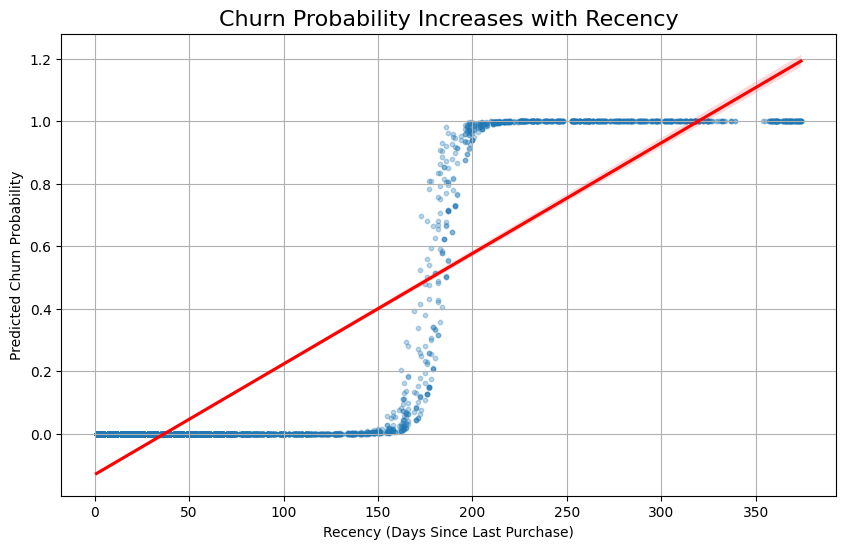

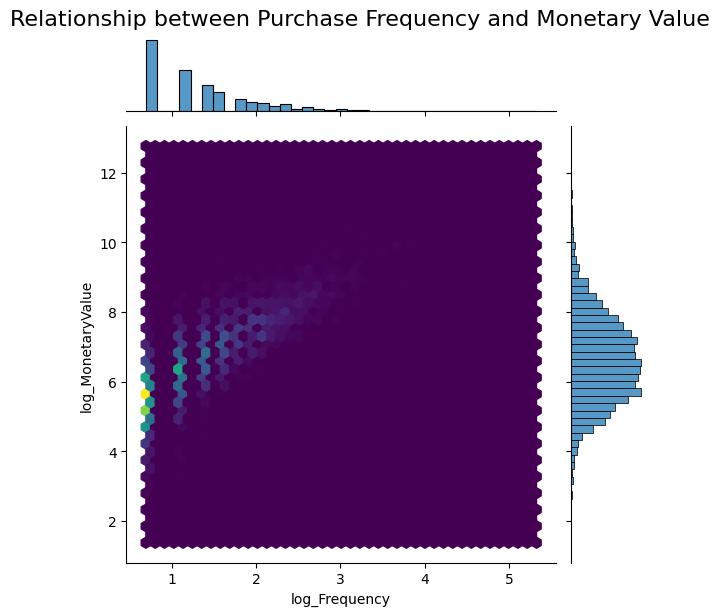

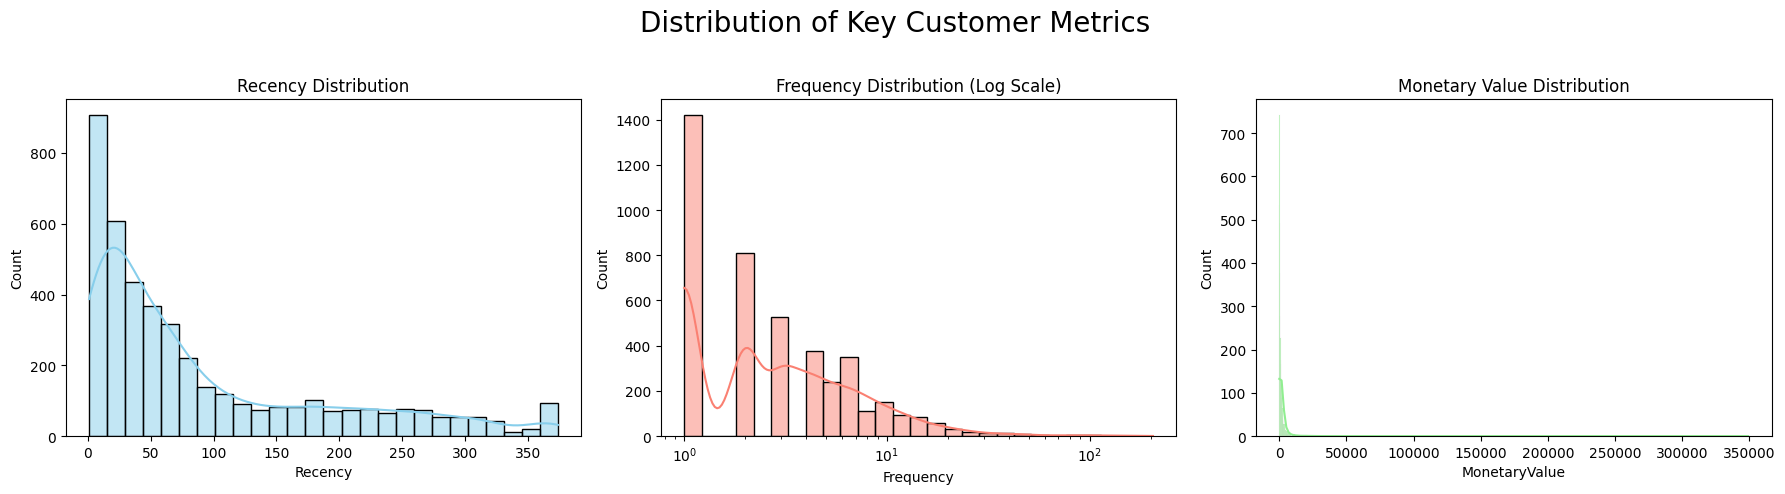

In [22]:
# =============================================================================
# Insight: Detailed Visualizations of Key Correlations and Distributions
# =============================================================================
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import numpy as np # FIX: Added the missing import for numpy

# --- Load Data ---
# This ensures the dataframe is loaded correctly if running this cell independently.
project_root = Path().resolve().parent
customer_data_path = project_root / "01_data" / "processed" / "final_dashboard_data.csv"
customer_df = pd.read_csv(customer_data_path)

# --- 1. Recency vs. Churn Probability (The Strongest Relationship) ---
# A regression plot is perfect for visualizing the linear relationship and the trend.
plt.figure(figsize=(10, 6))
sns.regplot(
    x='Recency', 
    y='Churn_Probability', 
    data=customer_df,
    line_kws={'color': 'red'}, # Style the trendline
    scatter_kws={'alpha': 0.3, 's': 10} # Make scatter points semi-transparent
)
plt.title('Churn Probability Increases with Recency', fontsize=16)
plt.xlabel('Recency (Days Since Last Purchase)')
plt.ylabel('Predicted Churn Probability')
plt.grid(True)
plt.show()


# --- 2. Frequency vs. Monetary Value (Understanding Customer Value) ---
# A jointplot is excellent because it shows both the relationship between two variables 
# and the distribution of each variable on its own axis.
# Note: We'll plot a sample of the data for performance and clarity if the dataset is large.
# We also log-transform MonetaryValue and Frequency for better visualization of the skewed data.

# Add a small constant to avoid log(0) errors
customer_df['log_Frequency'] = np.log(customer_df['Frequency'] + 1)
customer_df['log_MonetaryValue'] = np.log(customer_df['MonetaryValue'] + 1)

sns.jointplot(
    x='log_Frequency', 
    y='log_MonetaryValue', 
    data=customer_df,
    kind='hex', # 'hex' is great for large datasets, 'scatter' is also an option
    cmap='viridis'
)
plt.suptitle('Relationship between Purchase Frequency and Monetary Value', y=1.02, fontsize=16)
plt.show()


# --- 3. Distribution of Core RFM Metrics ---
# Histograms help us understand the profile of the overall customer base.
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Distribution of Key Customer Metrics', fontsize=20)

# Recency Distribution
sns.histplot(customer_df['Recency'], ax=axes[0], kde=True, color='skyblue')
axes[0].set_title('Recency Distribution')

# Frequency Distribution (on a log scale for better visibility)
sns.histplot(customer_df['Frequency'], ax=axes[1], kde=True, color='salmon', log_scale=True)
axes[1].set_title('Frequency Distribution (Log Scale)')

# Monetary Value Distribution
sns.histplot(customer_df['MonetaryValue'], ax=axes[2], kde=True, color='lightgreen')
axes[2].set_title('Monetary Value Distribution')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
